pip install git+https://git.fmrib.ox.ac.uk/fsl/fslnets.git

Need to be run to use this

# Have to rerun everything when i have more subjects - as the group ICA needs to be re-estimated and then all that comes afterwards (which is essentially everything)

For future self:
* don't use the _Z files in .dr folders. Less recommended in my understanding. 

* Do subgroups analysis


* to install packages and maybe run some stuff in the terminal I might need sometimes to run: conda activate myenv


# Import stuff + params

In [4]:
from fsl import nets
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# need to set up to run fsl.
os.environ['FSLDIR'] = '/export/home/ranigera/fsl'
os.environ['PATH'] += ':/export/home/ranigera/fsl/bin'

group_ICA_path = '/export/home/ranigera/IDCH-rsfMRI/data/group_ICA'
rs_data_path = '/export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data'
rs_data_path_IDCH_sub_Nums = '/export/home/ranigera/IDCH-rsfMRI/data/pre_proc_data_IDCH_subNums'

whole_network_path = '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks'

input_files_file_name = 'input_files.txt'
input_files_txt_path = os.path.join(group_ICA_path, input_files_file_name)
# n_ICs = 50 # number of independent components
TR = 0.70 # repetition time in seconds

# (original) file_format:
any_session_file_format = '_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz'
stage2_ic_file_prefix = 'dr_stage2_ic' # move to params

# R01 to IDCH mapping:
mapping_R01_to_IDCH = {'222': '101', '183': '102', '216': '103', '192': '104', '251': '105', '206': '106', '180': '107', '184': '108', '169': '109', '207': '110',
                       '159': '111', '115': '112', '114': '113', '232': '114', '173': '115', '171': '117', '215': '118', '265': '119', '177': '120', '269': '121',
                       '261': '122'}

main_behav_file = '/export/home/ranigera/IDCH-rsfMRI/data/behav_data/merged_behav_data.csv'

In [5]:
n_ICs=20 # number of independent components
# run slices_summary:
# check if exists:
if not os.path.exists(f'{group_ICA_path}/groupICA{n_ICs}.sum'):
    os.system(f'slices_summary {group_ICA_path}/groupICA{n_ICs}/melodic_IC 4 $FSLDIR/data/standard/MNI152_T1_2mm {group_ICA_path}/groupICA{n_ICs}.sum -1')


## concatenate the time series per subject

In [6]:
concat_ts_path = os.path.join(whole_network_path, 'concatenated_IC_ts')
if not os.path.exists(concat_ts_path):
    os.makedirs(concat_ts_path)

dual_regressed_path = os.path.join(f'{group_ICA_path}/groupICA{n_ICs}.dr')
file_list = sorted(glob.glob(f'{dual_regressed_path}/*stage1*.txt'))

maching_IDCH_sub_list = sorted(mapping_R01_to_IDCH.values())

for i in range(0, len(file_list), 2):
    sub_data1 = np.loadtxt(file_list[i])
    sub_data2 = np.loadtxt(file_list[i+1])
    # concatenate the two subjects' data
    sub_data_concat = np.concatenate((sub_data1, sub_data2), axis=0)
    # save the concatenated data
    np.savetxt(f'{concat_ts_path}/dr_stage1_{maching_IDCH_sub_list[i//2]}.txt', sub_data_concat, fmt='%.10g')


# Explore all data (across all subjects)

In [56]:
ts = nets.load(f'{concat_ts_path}', 0.70, varnorm=0, nruns=2, thumbnaildir=f'{group_ICA_path}/groupICA{n_ICs}.sum')

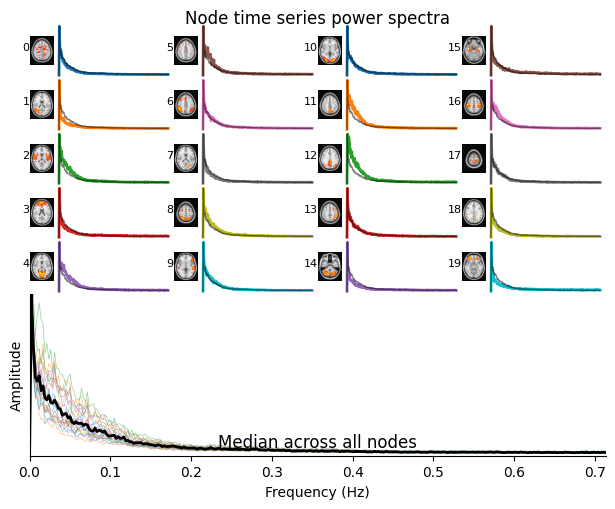

In [57]:
nets.plot_spectra(ts);

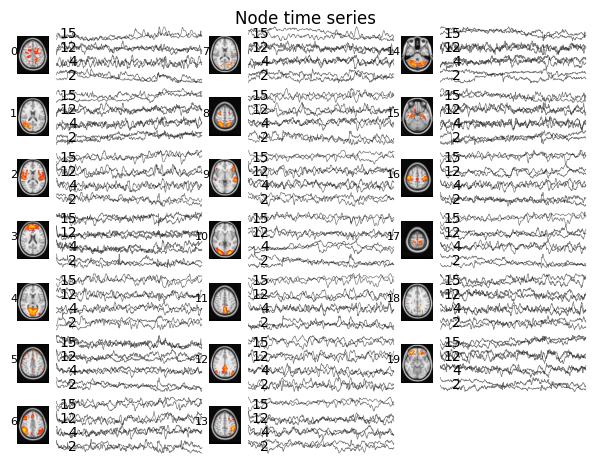

In [59]:
nets.plot_timeseries(ts)
plt.show()


In [ ]:
# If I have bad components that I want to clean up.
#nets.clean(ts, goodnodes, True)


In [41]:
# # plot time series for each component (each subject is a line):
# for i in range(ts.ts[0].shape[2]):
#     for j in range(len(ts.ts)):
#         plt.plot(ts.ts[j][:,:,i][0])
#     plt.title(f'IC {i}')
#     plt.show()


In [153]:
Fnetmats = nets.netmats(ts, 'corr',   True)
Pnetmats = nets.netmats(ts, 'ridgep', True, 0.1) # partial correlations with regularization

In [140]:
Znet_F, Mnet_F = nets.groupmean(ts, Fnetmats, False)
# NOTE: Seeing this 'invalid value encountered in true_divide' should be fine according to their tutorial (fsl's)


invalid value encountered in divide


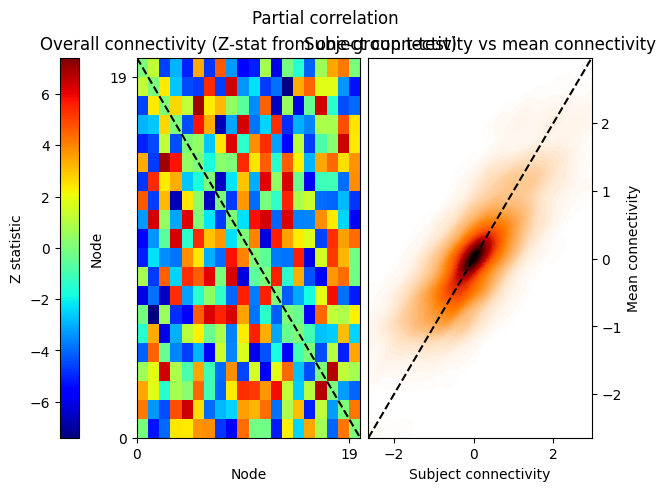

In [141]:
Znet_P, Mnet_P = nets.groupmean(ts, Pnetmats, True, 'Partial correlation') # "saves out both the simple average of netmats across all subjects (Mnet) and the results of a simple one-group t-test (against zero) across subjects as Z values (Znet)."
# NOTE: Seeing this 'invalid value encountered in true_divide' should be fine according to their tutorial (fsl's)
# NOTE: I think the left is the result of one sample t-test at each edge. not the average partial correlation (which is in Mnet_P)

([0, 7, 15, 1, 14, 18, 19, 3, 12, 9, 17, 16, 5, 2, 13, 6, 11, 8, 4, 10],
 array([[8.00000000e+00, 4.00000000e+00, 0.00000000e+00, 2.00000000e+00],
        [1.10000000e+01, 2.00000000e+01, 4.94811436e-03, 3.00000000e+00],
        [1.20000000e+01, 9.00000000e+00, 2.42479181e-02, 2.00000000e+00],
        [5.00000000e+00, 2.00000000e+00, 2.77946673e-02, 2.00000000e+00],
        [1.60000000e+01, 2.30000000e+01, 3.59361217e-02, 3.00000000e+00],
        [2.20000000e+01, 1.70000000e+01, 6.13888864e-02, 3.00000000e+00],
        [1.30000000e+01, 6.00000000e+00, 6.66476836e-02, 2.00000000e+00],
        [2.10000000e+01, 1.00000000e+01, 8.27556912e-02, 4.00000000e+00],
        [0.00000000e+00, 7.00000000e+00, 9.72927069e-02, 2.00000000e+00],
        [2.40000000e+01, 2.60000000e+01, 1.87782069e-01, 5.00000000e+00],
        [3.00000000e+00, 2.50000000e+01, 2.71210963e-01, 4.00000000e+00],
        [1.50000000e+01, 1.00000000e+00, 2.74433387e-01, 2.00000000e+00],
        [1.40000000e+01, 1.80000000e+01

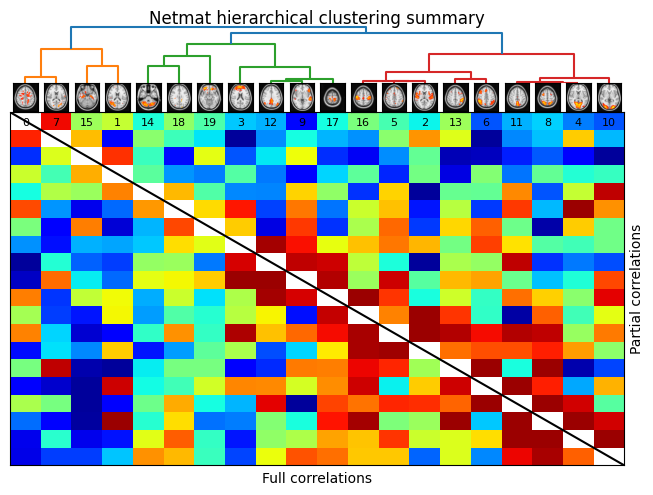

In [156]:
nets.plot_hierarchy(ts, Znet_F, Znet_P, 'Full correlations', 'Partial correlations')
# NOTE: full correlation drives the clustering, partial correlation just shown for comparison.

## code and instructions to run nets.web

In [60]:
# nets.web(ts, (Znet_F, Znet_P), ('Full correlation', 'Partial correlation'))
# this would actually work only by running it in the terminal in fslpython
# after the running the previous stuff I ran here:

# so start by entering fslpython in the terminal and then copy paste the following:
from fsl import nets
import os
n_ICs=20 # number of independent components
group_ICA_path = '/export/home/ranigera/IDCH-rsfMRI/data/group_ICA'

if not os.path.exists(f'{group_ICA_path}/groupICA{n_ICs}.sum'):
    os.system(f'slices_summary {group_ICA_path}/groupICA{n_ICs}/melodic_IC 4 $FSLDIR/data/standard/MNI152_T1_2mm {group_ICA_path}/groupICA{n_ICs}.sum -1')

ts = nets.load(f'{group_ICA_path}/groupICA{n_ICs}.dr', 0.70, varnorm=0, thumbnaildir=f'{group_ICA_path}/groupICA{n_ICs}.sum')
Fnetmats = nets.netmats(ts, 'corr',   True)
Pnetmats = nets.netmats(ts, 'ridgep', True, 0.1) # partial correlations with regularization
Znet_F, Mnet_F = nets.groupmean(ts, Fnetmats, False)
Znet_P, Mnet_P = nets.groupmean(ts, Pnetmats, True, 'Partial correlation') # "saves out both the simple average of netmats across all subjects (Mnet) and the results of a simple one-group t-test (against zero) across subjects as Z values (Znet)."
nets.web(ts, (Znet_F, Znet_P), ('Full correlation', 'Partial correlation'))


# Analyze corr with behavior 

## Get behavior data

In [34]:
# load the behavior data:
main_behav_data = pd.read_csv(main_behav_file)
# change subID to int:
main_behav_data['subID'] = main_behav_data['subID'].astype(int)
main_behav_data

# behav_vars_if_interest = ['SRM_score', 'std_diary', 'normed_std_diary', 'routine_mean', 'meanVal_relativeDiff_deval_SQRT', 'devaluation', 'at_least_one_response_test', 'at_least_one_response_combined', 'mood', 'Anxiety', 'Stress']
behav_vars_if_interest = ['SRM_score', 'std_diary', 'routine_mean', 'meanVal_relativeDiff_deval_SQRT', 'devaluation', 'at_least_one_response_test']

## Run network-behavior univariate correlation analysis (each node is tested separately)

In [35]:
def network_univariate_corr_w_behav_analysis(behav_var, n_ICs=20):
    # Initial general stuff:
    univariate_behav_corr_path = os.path.join(whole_network_path, f'univariateICA{n_ICs}.behavior_corr')
    if not os.path.exists(univariate_behav_corr_path):
        os.makedirs(univariate_behav_corr_path)

    univariate_behav_corr_input_data_folder = os.path.join(univariate_behav_corr_path, 'input_data')
    if not os.path.exists(univariate_behav_corr_input_data_folder):
        os.makedirs(univariate_behav_corr_input_data_folder)

    # ----------------------------------------------------------------------------------------------------------
    # Prepare design matrix
    # ----------------------------------------------------------------------------------------------------------
    # get the data with subID and the behavior variable (and remove NaNs):
    behav_data = main_behav_data[['subID', behav_var]].dropna().reset_index(drop=True)
    num_data_points = len(behav_data['subID'])
    demeaned_behav_data = behav_data[behav_var] - behav_data[behav_var].mean()

    # Prepare the .mat file content
    # --------------------------------------------------------------
    header = f"""/NumWaves\t1
    /NumPoints\t{num_data_points}

    /Matrix
    """
    # Format the matrix content
    matrix_content = "\n".join([f"{value}\t" for value in demeaned_behav_data])
    # Combine header and matrix content
    design_matrix_content = header + matrix_content
    # print(design_matrix_content)
    # Write the design matrix to a file
    output_file = f'design_behav_corr_{behav_var}.mat'
    output_file = os.path.join(univariate_behav_corr_input_data_folder, output_file)
    with open(output_file, 'w') as file:
        file.write(design_matrix_content)
    print(f"Design matrix file '{output_file}' created successfully!")


    # Prepare the .con file content
    # --------------------------------------------------------------
    # Parameters for the contrast file
    num_waves = 1  # As per your new design, only one EV
    num_contrasts = 1  # Two contrasts: positive and negative

    # Matrix for contrasts
    # Positive correlation: 1 for the EV
    # Negative correlation: -1 for the EV
    contrast_matrix = [
        [1.0],  # Positive correlation
    ]

    # Create the .con file content
    header = f"""/NumWaves\t{num_waves}
    /NumContrasts\t{num_contrasts}

    /Matrix
    """
    # Format the matrix content
    matrix_content = "\n".join(["\t".join([f"{value}" for value in row]) for row in contrast_matrix])
    # Combine header and matrix content
    contrast_matrix_content = header + matrix_content
    # print(contrast_matrix_content)
    # Write the contrast matrix to a file
    output_file = f'design_behav_corr_{behav_var}_pos_corr.con'
    output_file = os.path.join(univariate_behav_corr_input_data_folder, output_file)
    with open(output_file, 'w') as file:
        file.write(contrast_matrix_content)
    print(f"Contrast matrix file '{output_file}' created successfully!")

    # Create the .con file content for negative correlation [HAS TO BE DONE SEPERATELY BECAUSE OF HOW THE nets.glm HANDLE THE CONTRASTS WITH ONE EV]
    contrast_matrix = [
        [-1.0]  # Negative correlation
    ]
    # Format the matrix content
    matrix_content = "\n".join(["\t".join([f"{value}" for value in row]) for row in contrast_matrix])
    # Combine header and matrix content
    contrast_matrix_content = header + matrix_content
    # print(contrast_matrix_content)
    # Write the contrast matrix to a file
    output_file = f'design_behav_corr_{behav_var}_neg_corr.con'
    output_file = os.path.join(univariate_behav_corr_input_data_folder, output_file)
    with open(output_file, 'w') as file:
        file.write(contrast_matrix_content)
    print(f"Contrast matrix file '{output_file}' created successfully!")


    # ----------------------------------------------------------------------------------------------------------
    ## Load as the relevant data as a ts object
    # ----------------------------------------------------------------------------------------------------------
    relevant_file = [f'{concat_ts_path}/dr_stage1_{subj}.txt' for subj in behav_data.subID]
    ts = nets.load(relevant_file, 0.70, varnorm=0, nruns=2, thumbnaildir=f'{group_ICA_path}/groupICA{n_ICs}.sum')
    Fnetmats = nets.netmats(ts, 'corr',   True)
    Pnetmats = nets.netmats(ts, 'ridgep', True, 0.1) # partial correlations with regularization

    # ----------------------------------------------------------------------------------------------------------
    # Test Correlation between behavior and the edges (correlation between nodes)
    # ----------------------------------------------------------------------------------------------------------
    print(f'\n---------------------------------   Positive correlation for {behav_var} [with partial correlation]:   ---------------------------------')
    p_corr,p_uncorr = nets.glm(ts, Pnetmats, os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}.mat'), os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}_pos_corr.con'))
    plt.show()
    print(f'---------------------------------   Negative correlation for {behav_var} [with partial correlation]:   ---------------------------------')
    p_corr,p_uncorr = nets.glm(ts, Pnetmats, os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}.mat'), os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}_neg_corr.con'))
    plt.show()
    print(f'---------------------------------   Positive correlation for {behav_var} [with full correlation]:   ---------------------------------')
    p_corr,p_uncorr = nets.glm(ts, Fnetmats, os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}.mat'), os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}_pos_corr.con'))
    plt.show()
    print(f'---------------------------------   Negative correlation for {behav_var} [with full correlation]:   ---------------------------------')
    p_corr,p_uncorr = nets.glm(ts, Fnetmats, os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}.mat'), os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}_neg_corr.con'))
    plt.show()

Design matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_SRM_score.mat' created successfully!
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_SRM_score_pos_corr.con' created successfully!
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_SRM_score_neg_corr.con' created successfully!

---------------------------------   Positive correlation for SRM_score [with partial correlation]:   ---------------------------------
21362

---------------------------
Contrast 1 [1] - no results
---------------------------



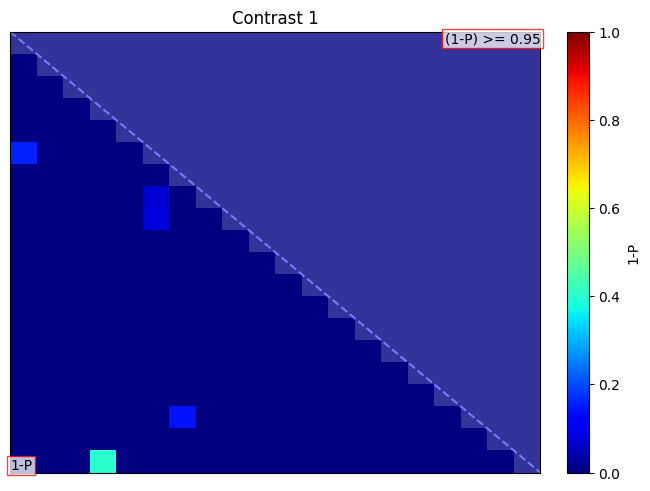

---------------------------------   Negative correlation for SRM_score [with partial correlation]:   ---------------------------------
21438

----------------------------
Contrast 1 [-1] - no results
----------------------------



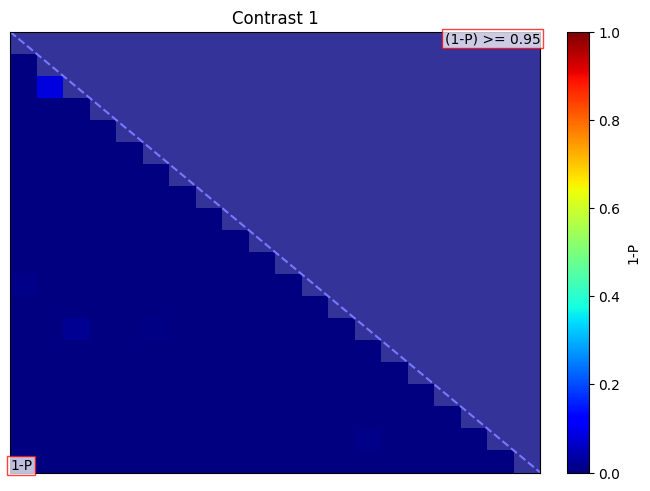

---------------------------------   Positive correlation for SRM_score [with full correlation]:   ---------------------------------
21576

---------------------------
Contrast 1 [1] - no results
---------------------------



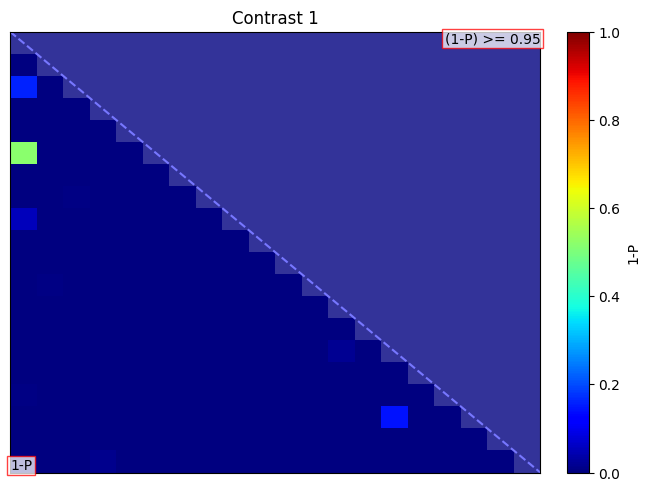

---------------------------------   Negative correlation for SRM_score [with full correlation]:   ---------------------------------
21648

----------------------------
Contrast 1 [-1] - no results
----------------------------



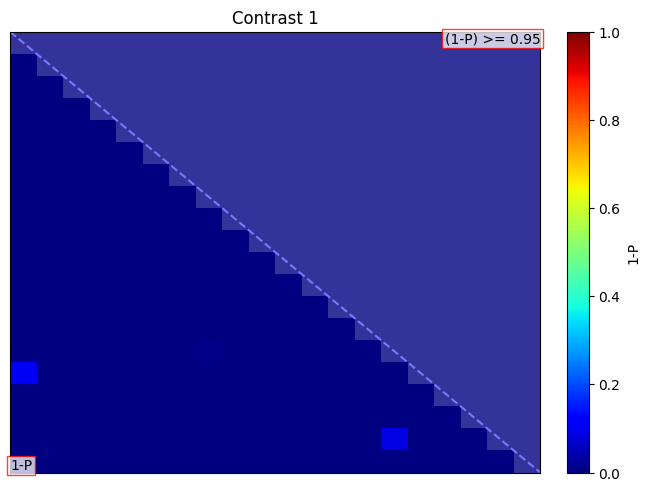

Design matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_std_diary.mat' created successfully!
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_std_diary_pos_corr.con' created successfully!
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_std_diary_neg_corr.con' created successfully!

---------------------------------   Positive correlation for std_diary [with partial correlation]:   ---------------------------------
21732

---------------------------
Contrast 1 [1] - no results
---------------------------



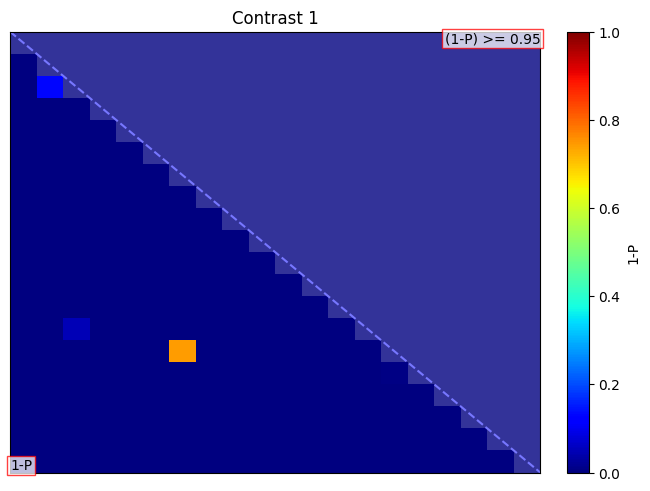

---------------------------------   Negative correlation for std_diary [with partial correlation]:   ---------------------------------
21804

----------------------------
Contrast 1 [-1] - no results
----------------------------



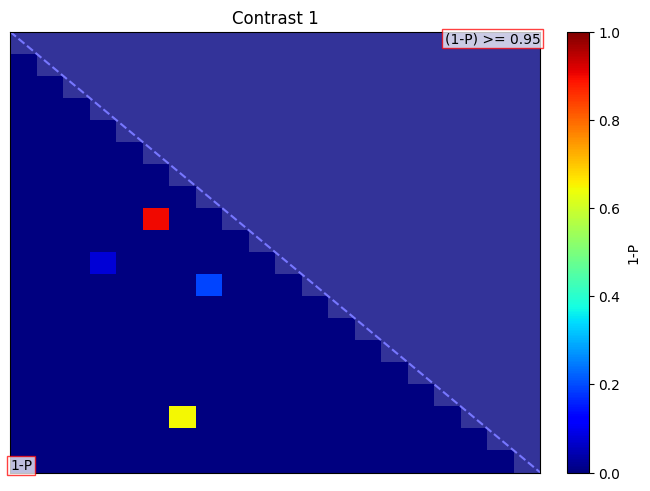

---------------------------------   Positive correlation for std_diary [with full correlation]:   ---------------------------------
21879

---------------------------
Contrast 1 [1] - no results
---------------------------



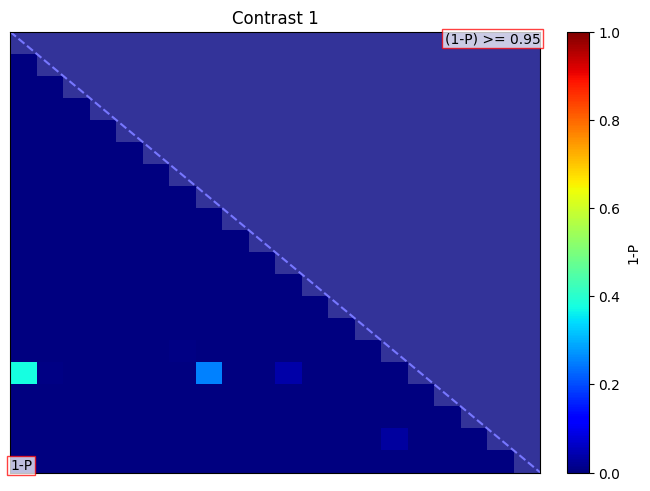

---------------------------------   Negative correlation for std_diary [with full correlation]:   ---------------------------------
21951

----------------------------
Contrast 1 [-1] - no results
----------------------------



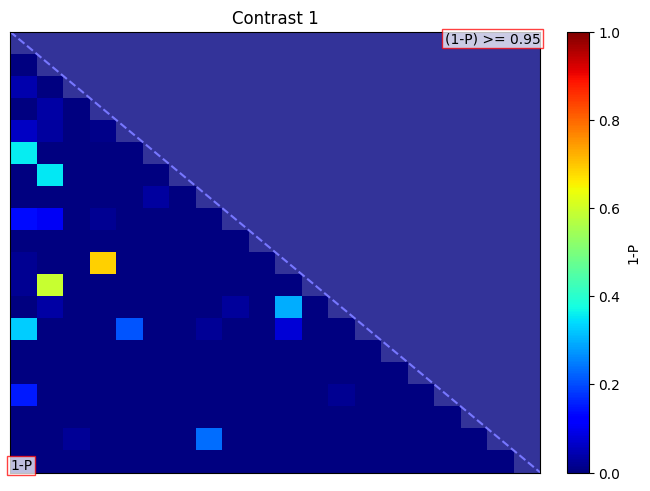

Design matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_routine_mean.mat' created successfully!
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_routine_mean_pos_corr.con' created successfully!
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_routine_mean_neg_corr.con' created successfully!

---------------------------------   Positive correlation for routine_mean [with partial correlation]:   ---------------------------------
22027

---------------------------
Contrast 1 [1] - no results
---------------------------



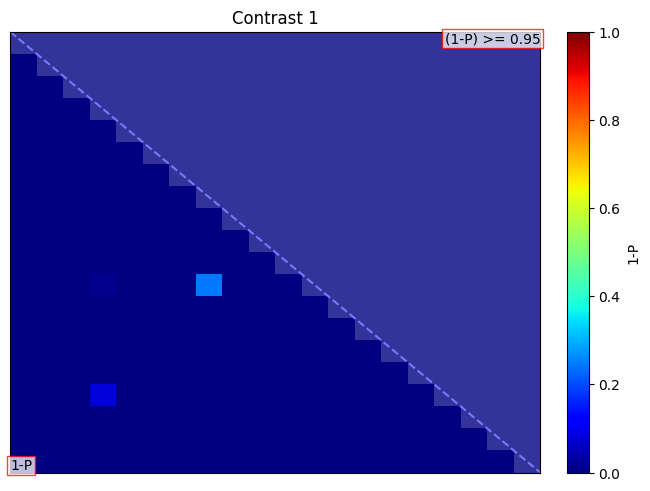

---------------------------------   Negative correlation for routine_mean [with partial correlation]:   ---------------------------------
22099

----------------------------
Contrast 1 [-1] - no results
----------------------------



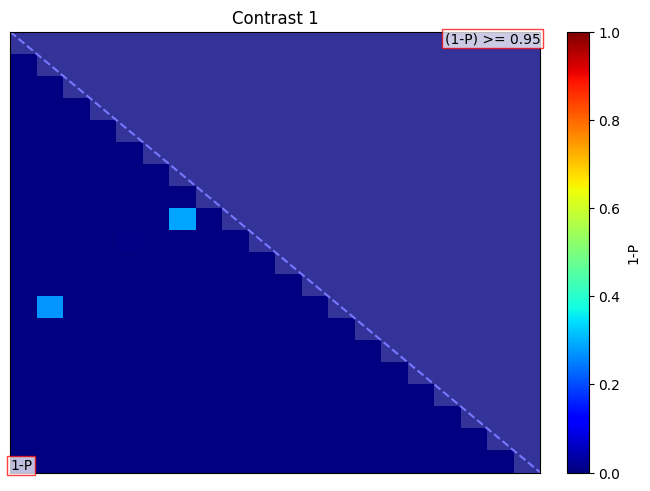

---------------------------------   Positive correlation for routine_mean [with full correlation]:   ---------------------------------
22170

---------------------------
Contrast 1 [1] - no results
---------------------------



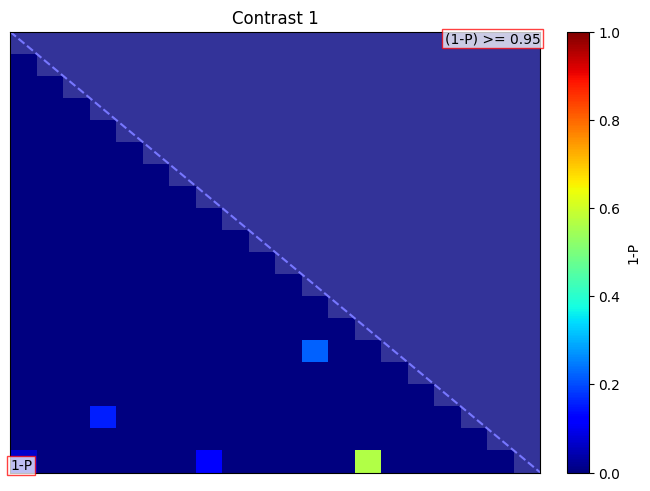

---------------------------------   Negative correlation for routine_mean [with full correlation]:   ---------------------------------
22246

----------------------------
Contrast 1 [-1] - no results
----------------------------



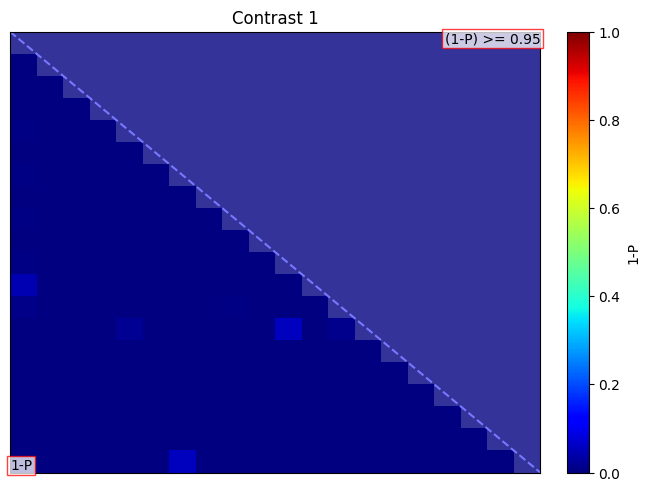

Design matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_meanVal_relativeDiff_deval_SQRT.mat' created successfully!
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_meanVal_relativeDiff_deval_SQRT_pos_corr.con' created successfully!
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_meanVal_relativeDiff_deval_SQRT_neg_corr.con' created successfully!

---------------------------------   Positive correlation for meanVal_relativeDiff_deval_SQRT [with partial correlation]:   ---------------------------------
22322

---------------------------
Contrast 1 [1] - no results
---------------------------



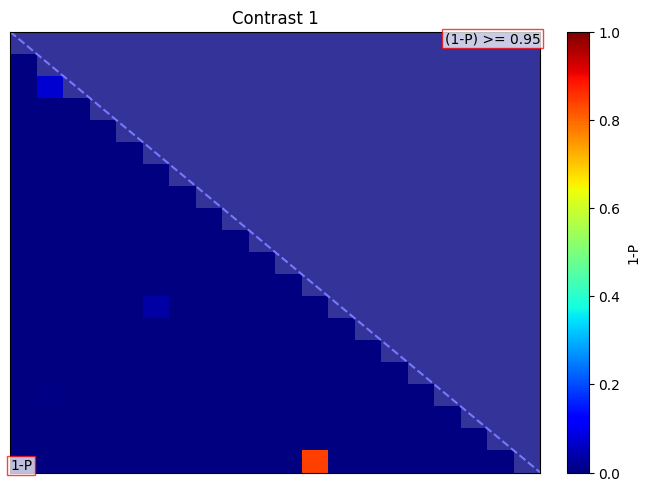

---------------------------------   Negative correlation for meanVal_relativeDiff_deval_SQRT [with partial correlation]:   ---------------------------------
22394

----------------------------
Contrast 1 [-1] - no results
----------------------------



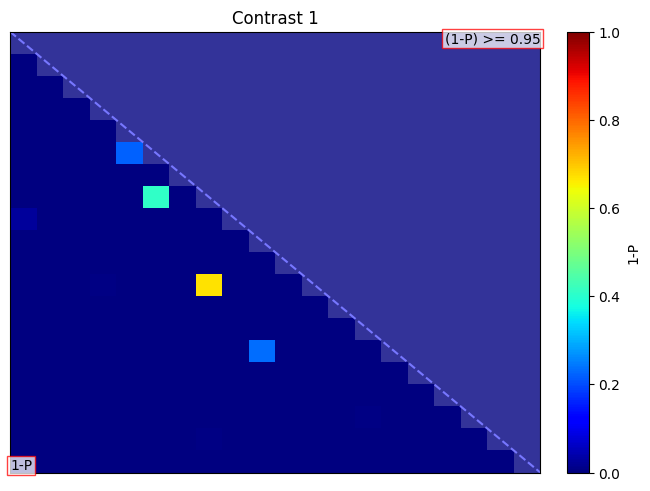

---------------------------------   Positive correlation for meanVal_relativeDiff_deval_SQRT [with full correlation]:   ---------------------------------
22465

---------------------------
Contrast 1 [1] - no results
---------------------------



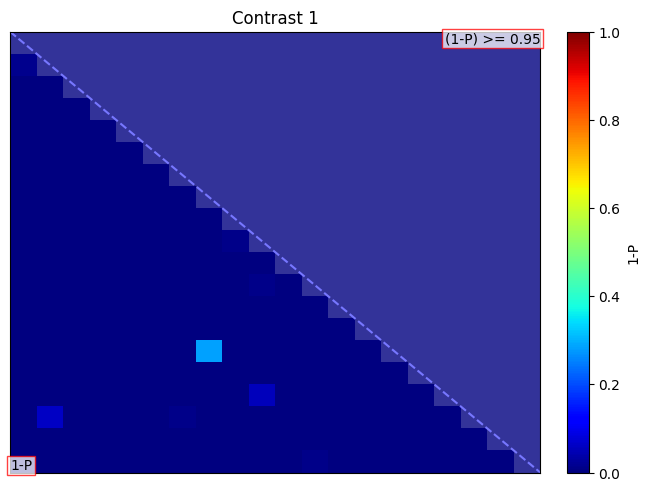

---------------------------------   Negative correlation for meanVal_relativeDiff_deval_SQRT [with full correlation]:   ---------------------------------
22539

----------------------------
Contrast 1 [-1] - no results
----------------------------



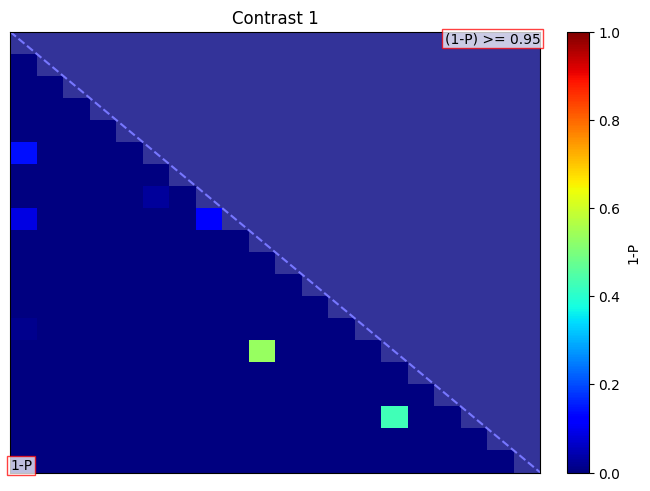

Design matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_devaluation.mat' created successfully!
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_devaluation_pos_corr.con' created successfully!
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_devaluation_neg_corr.con' created successfully!

---------------------------------   Positive correlation for devaluation [with partial correlation]:   ---------------------------------
22615

---------------------------
Contrast 1 [1] - no results
---------------------------



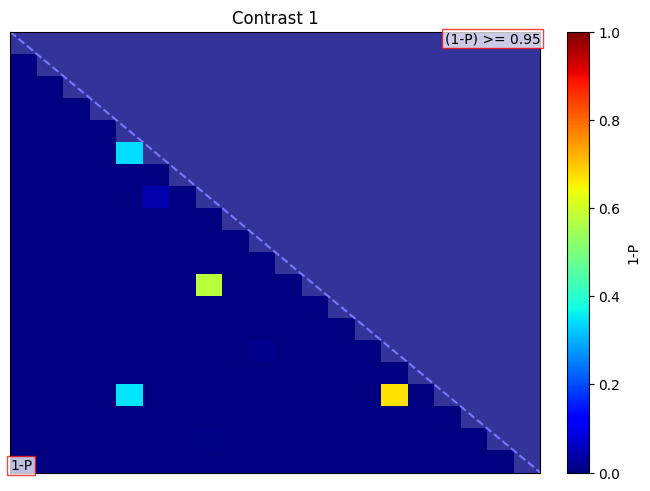

---------------------------------   Negative correlation for devaluation [with partial correlation]:   ---------------------------------
22691

---------------
Contrast 1 [-1]
---------------

Node i | Node j | T statistic | P value
------ | ------ | ----------- | -------
11     | 19     | 4.9540434   | 0.9968 


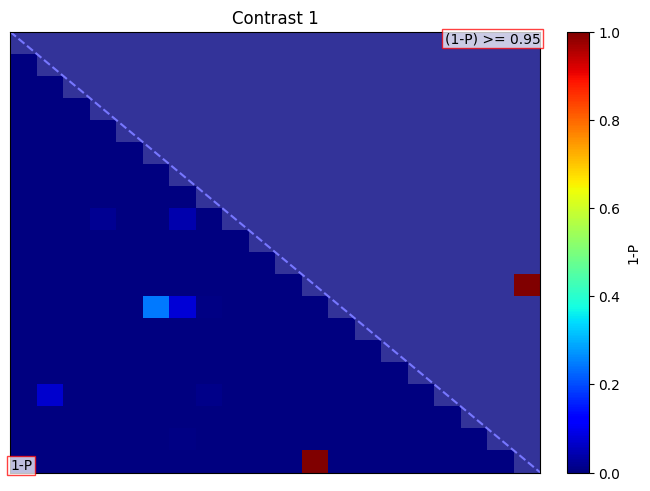

---------------------------------   Positive correlation for devaluation [with full correlation]:   ---------------------------------
22762

---------------------------
Contrast 1 [1] - no results
---------------------------



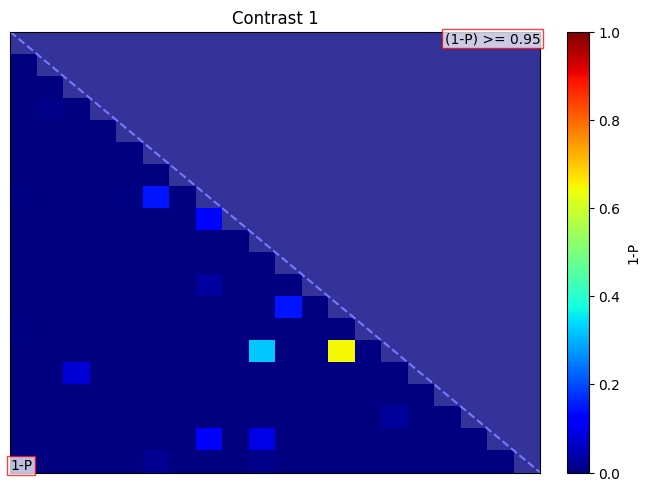

---------------------------------   Negative correlation for devaluation [with full correlation]:   ---------------------------------
22834

----------------------------
Contrast 1 [-1] - no results
----------------------------



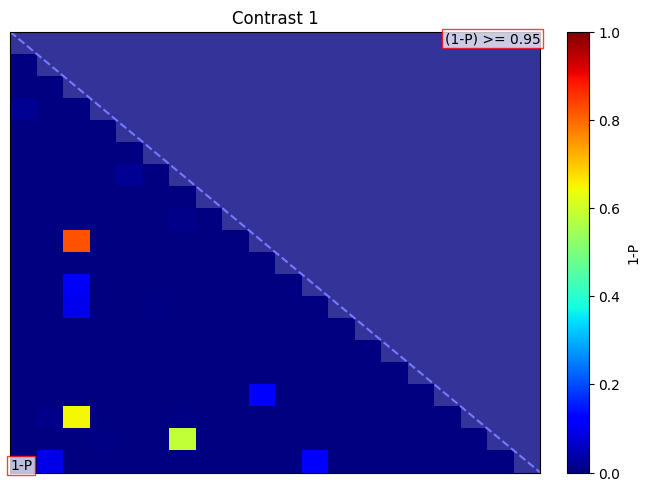

Design matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_at_least_one_response_test.mat' created successfully!
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_at_least_one_response_test_pos_corr.con' created successfully!
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_corr/input_data/design_behav_corr_at_least_one_response_test_neg_corr.con' created successfully!

---------------------------------   Positive correlation for at_least_one_response_test [with partial correlation]:   ---------------------------------
22911

---------------------------
Contrast 1 [1] - no results
---------------------------



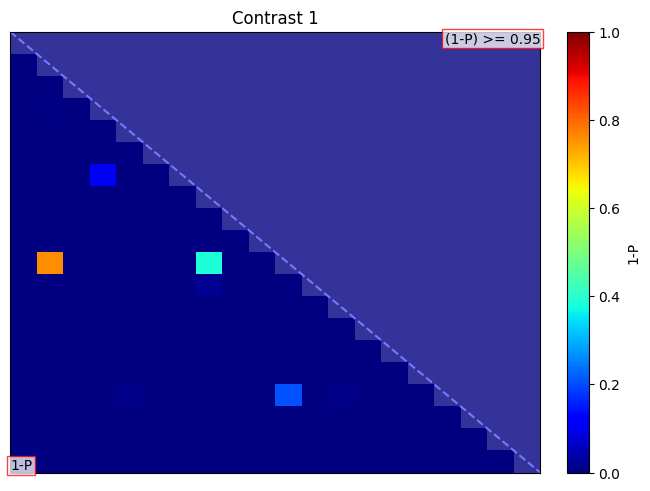

---------------------------------   Negative correlation for at_least_one_response_test [with partial correlation]:   ---------------------------------
22983

----------------------------
Contrast 1 [-1] - no results
----------------------------



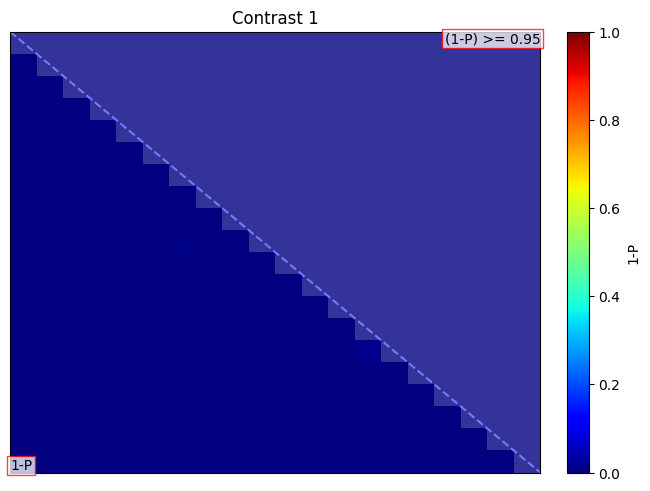

---------------------------------   Positive correlation for at_least_one_response_test [with full correlation]:   ---------------------------------
23058

--------------
Contrast 1 [1]
--------------

Node i | Node j | T statistic | P value
------ | ------ | ----------- | -------
4      | 7      | 4.1846533   | 0.9678 


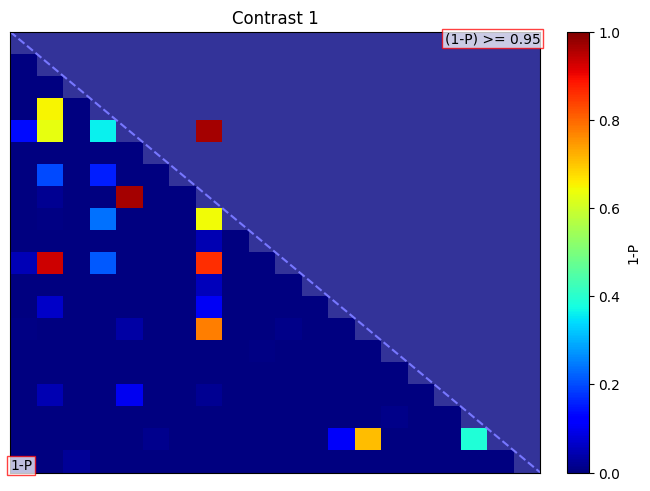

---------------------------------   Negative correlation for at_least_one_response_test [with full correlation]:   ---------------------------------
23130

----------------------------
Contrast 1 [-1] - no results
----------------------------



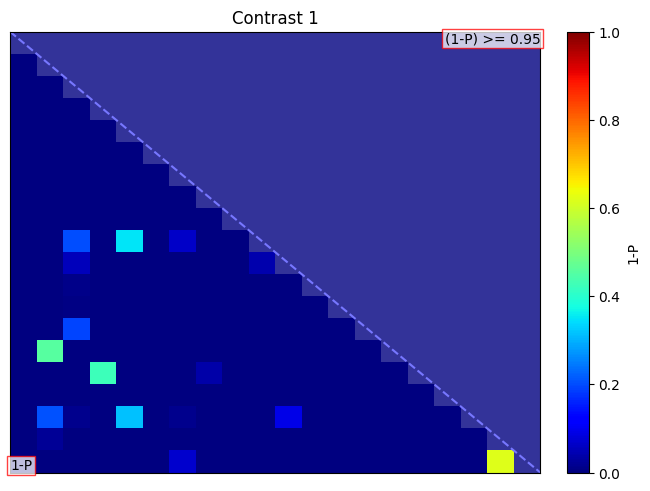

In [36]:
for behav_var in behav_vars_if_interest:
    network_univariate_corr_w_behav_analysis(behav_var, n_ICs=20)

In [30]:
def plot_result_details(behav_var, partial_corr=True, pos_corr=True, n_ICs=20):
    if pos_corr:
        corr_type = 'pos_corr'
    else:
        corr_type = 'neg_corr'

    # Initial general stuff:
    univariate_behav_corr_path = os.path.join(whole_network_path, f'univariateICA{n_ICs}.behavior_corr')
    univariate_behav_corr_input_data_folder = os.path.join(univariate_behav_corr_path, 'input_data')

    # ----------------------------------------------------------------------------------------------------------
    # Prepare design matrix
    # ----------------------------------------------------------------------------------------------------------
    # get the data with subID and the behavior variable (and remove NaNs):
    behav_data = main_behav_data[['subID', behav_var]].dropna().reset_index(drop=True)

    # ----------------------------------------------------------------------------------------------------------
    ## Load as the relevant data as a ts object
    # ----------------------------------------------------------------------------------------------------------
    relevant_file = [f'{concat_ts_path}/dr_stage1_{subj}.txt' for subj in behav_data.subID]
    ts = nets.load(relevant_file, 0.70, varnorm=0, nruns=2, thumbnaildir=f'{group_ICA_path}/groupICA{n_ICs}.sum')
    if partial_corr:
        netmats = nets.netmats(ts, 'ridgep', True, 0.1)
    else:
        netmats = nets.netmats(ts, 'corr', True)
    # Fnetmats = nets.netmats(ts, 'corr',   True)
    # Pnetmats = nets.netmats(ts, 'ridgep', True, 0.1) # partial correlations with regularization

    # ----------------------------------------------------------------------------------------------------------
    p_corr, p_uncorr = nets.glm(ts, netmats, os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}.mat'), os.path.join(univariate_behav_corr_input_data_folder, f'design_behav_corr_{behav_var}_{corr_type}.con'))
    Znet, Mnet = nets.groupmean(ts, netmats, False)
    nets.boxplots(ts, netmats, Znet, p_corr[0])
    plt.show()

# if I have groups I should use this I think:
# nets.boxplots(ts, Fnetmats, Znet_F, p_corr[0], groups=(6, 6))

# ABOUT:
# "Each pair of thumbnails corresponds to one position in the NxN network matrix and the node numbers are listed in the text captions.
# The coloured bar joining each pair of nodes tells you what the overall group-average connection strength is: thicker means a stronger connection; red means it's positive, and blue means that the connection is "negative" (meaning that the two nodes tend to anti-correlate on average).
# The "P value" numbers tell you the 1-p-values - so the higher these are, the more significantly different this edge strength is between the two groups. Anything less than 0.95 is not significant, after correcting for multiple comparisons."

20171

--------------
Contrast 1 [1]
--------------

Node i | Node j | T statistic | P value
------ | ------ | ----------- | -------
4      | 7      | 4.1846533   | 0.9678 


invalid value encountered in divide


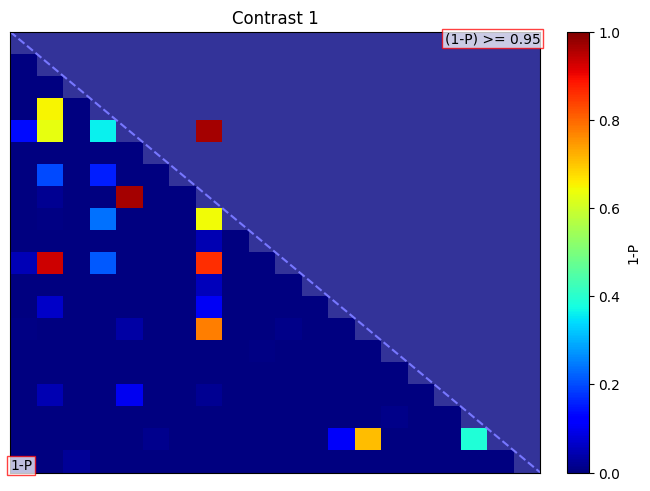

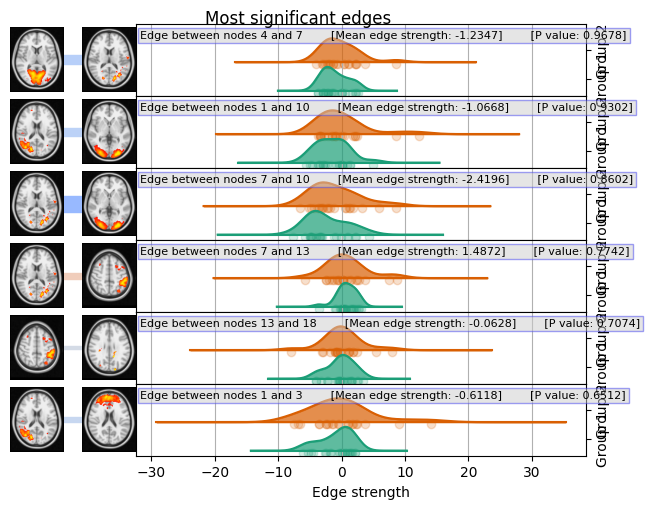

In [31]:
plot_result_details('at_least_one_response_test', partial_corr=False, pos_corr=True, n_ICs=20)

# Analyze univariate of edges corr with binary outcomes (sub-group analysis)
The idea is that I am binarizing variables and then do a group t-test

## Get behavior data

In [59]:
# load the behavior data:
main_behav_data = pd.read_csv(main_behav_file)
# change subID to int:
main_behav_data['subID'] = main_behav_data['subID'].astype(int)
main_behav_data['any_test_DTH_slips'] = (main_behav_data['at_least_one_response_test']>0).astype(float)
main_behav_data['any_combined_DTH_slips'] = (main_behav_data['at_least_one_response_combined']>0).astype(float)
# now binarize for meanVal_relativeDiff_deval_SQRT:
main_behav_data['any_App_slips'] = (main_behav_data['meanVal_relativeDiff_deval_SQRT']<1).astype(float)
behav_vars_if_interest = ['any_test_DTH_slips', 'any_combined_DTH_slips', 'any_App_slips']
main_behav_data

,subID,sequenceCompleted_test,sequenceCompleted_reacquisition,sequenceCompleted_combined,at_least_one_response_test,at_least_one_response_reacquisition,at_least_one_response_combined,devaluation,stillVal_minus_deval,preVal_relativeDiff_deval,...,std_diary,normed_std_diary,SRM_score,mood,Anxiety,Stress,routine_mean,any_test_DTH_slips,any_combined_DTH_slips,any_App_slips
0,101,1,11,12,1,11,12,0,34,1.000000,...,1281.631619,0.530220,2.200000,71.985294,34.367647,26.191176,3.593137,1.0,1.0,0.0
1,102,0,0,0,0,0,0,0,5,1.000000,...,966.548720,0.433184,4.125000,68.357143,22.000000,21.828571,3.638095,0.0,0.0,0.0
2,103,0,0,0,0,0,0,6,1,0.076923,...,761.555304,0.372977,6.000000,63.100000,20.471429,18.957143,3.823810,0.0,0.0,1.0
3,104,0,0,0,0,0,0,3,12,0.666667,...,1200.262012,0.519515,3.058824,68.457143,14.714286,14.814286,4.095238,0.0,0.0,1.0
4,105,3,0,3,4,0,4,0,9,1.000000,...,1444.988375,0.595996,1.882353,62.536232,33.927536,42.318841,4.376812,1.0,1.0,0.0
5,106,1,0,1,2,0,2,4,26,0.764706,...,NaN,NaN,NaN,90.724138,3.896552,9.327586,5.902299,1.0,1.0,1.0
6,107,0,0,0,0,0,0,0,10,1.000000,...,1376.074428,0.555342,1.954545,66.402985,42.507463,37.104478,4.457711,0.0,0.0,0.0
7,108,0,0,0,0,0,0,0,3,1.000000,...,1065.073426,0.452931,1.571429,70.609375,25.718750,15.906250,5.072917,0.0,0.0,0.0
8,109,0,0,0,0,0,0,2,25,0.862069,...,971.316793,0.462965,3.000000,86.630769,3.384615,5.400000,5.907692,0.0,0.0,1.0
9,110,0,0,0,1,0,1,7,7,0.333333,...,1014.818277,0.480114,4.600000,66.428571,12.442857,28.271429,5.219048,1.0,1.0,1.0


In [60]:
def network_univariate_subgroup_by_behav_analysis(behav_var, n_ICs=20):
    # Initial general stuff:
    univariate_behav_subgroup_path = os.path.join(whole_network_path, f'univariateICA{n_ICs}.behavior_subgroup_comparison')
    if not os.path.exists(univariate_behav_subgroup_path):
        os.makedirs(univariate_behav_subgroup_path)

    univariate_behav_subgroup_input_data_folder = os.path.join(univariate_behav_subgroup_path, 'input_data')
    if not os.path.exists(univariate_behav_subgroup_input_data_folder):
        os.makedirs(univariate_behav_subgroup_input_data_folder)

    # ----------------------------------------------------------------------------------------------------------
    # Prepare design matrix
    # ----------------------------------------------------------------------------------------------------------
    # get the data with subID and the behavior variable (and remove NaNs):
    behav_data = main_behav_data[['subID', behav_var]].dropna().reset_index(drop=True)
    num_data_points = len(behav_data['subID'])

    # Prepare the .mat file content
    # --------------------------------------------------------------
    header = f"""/NumWaves\t2
    /NumPoints\t{num_data_points}

    /Matrix
    """
    # Format the matrix content with two columns first column is 1 if  behav_data[behav_var] is 1 and the second column is 0 and vice versa:
    matrix_content = "\n".join([f"{1 if value == 1 else 0}\t{1 if value == 0 else 0}\t" for value in behav_data[behav_var]])
    # Combine header and matrix content
    design_matrix_content = header + matrix_content
    # print(design_matrix_content)
    # Write the design matrix to a file
    output_file = f'design_behav_subgroups_{behav_var}.mat'
    output_file = os.path.join(univariate_behav_subgroup_input_data_folder, output_file)
    with open(output_file, 'w') as file:
        file.write(design_matrix_content)
    print(f"Design matrix file '{output_file}' created successfully!")

    # Prepare the .con file content
    # -----------------------------
    # Parameters for the contrast file
    contrast_name1 = "Habit > Goal-directed"
    contrast_name2 = "Goal directed > Habit"
    num_waves = 2  # As per your new design, 2 EVs
    num_contrasts = 2  # Two contrasts: positive and negative

    # Matrix for contrasts
    # Positive correlation: 1 for the EV
    # Negative correlation: -1 for the EV
    contrast_matrix = [
        [1.0, -1.0],  # Habit > Goal-directed
        [-1.0, 1.0]  # Goal directed > Habit
    ]

    # Create the .con file content
    header = f"""/ContrastName1\t{contrast_name1}
    /ContrastName2\t{contrast_name2}
    /NumWaves\t{num_waves}
    /NumContrasts\t{num_contrasts}

    /Matrix
    """
    # Format the matrix content
    matrix_content = "\n".join(["\t".join([f"{value}" for value in row]) for row in contrast_matrix])
    # Combine header and matrix content
    contrast_matrix_content = header + matrix_content
    # print(contrast_matrix_content)
    # Write the contrast matrix to a file
    output_file = f'design_behav_subgroups_{behav_var}.con'
    output_file = os.path.join(univariate_behav_subgroup_input_data_folder, output_file)
    with open(output_file, 'w') as file:
        file.write(contrast_matrix_content)
    print(f"Contrast matrix file '{output_file}' created successfully!")

    # ----------------------------------------------------------------------------------------------------------
    ## Load as the relevant data as a ts object
    # ----------------------------------------------------------------------------------------------------------
    relevant_file = [f'{concat_ts_path}/dr_stage1_{subj}.txt' for subj in behav_data.subID]
    ts = nets.load(relevant_file, 0.70, varnorm=0, nruns=2, thumbnaildir=f'{group_ICA_path}/groupICA{n_ICs}.sum')
    Fnetmats = nets.netmats(ts, 'corr',   True)
    Pnetmats = nets.netmats(ts, 'ridgep', True, 0.1) # partial correlations with regularization

    # ----------------------------------------------------------------------------------------------------------
    # Test Correlation between behavior and the edges (correlation between nodes)
    # ----------------------------------------------------------------------------------------------------------
    print(f'\n---------------------------------   Subgroups analysis {behav_var} [with partial correlation]:   ---------------------------------')
    p_corr,p_uncorr = nets.glm(ts, Pnetmats, os.path.join(univariate_behav_subgroup_input_data_folder, f'design_behav_subgroups_{behav_var}.mat'), os.path.join(univariate_behav_subgroup_input_data_folder, f'design_behav_subgroups_{behav_var}.con'))
    plt.show()
    print(f'---------------------------------   Subgroups analysis {behav_var} [with full correlation]:   ---------------------------------')
    p_corr,p_uncorr = nets.glm(ts, Fnetmats, os.path.join(univariate_behav_subgroup_input_data_folder, f'design_behav_subgroups_{behav_var}.mat'), os.path.join(univariate_behav_subgroup_input_data_folder, f'design_behav_subgroups_{behav_var}.con'))
    plt.show()

Design matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_subgroup_comparison/input_data/design_behav_subgroups_any_test_DTH_slips.mat' created successfully!
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_subgroup_comparison/input_data/design_behav_subgroups_any_test_DTH_slips.con' created successfully!

---------------------------------   Subgroups analysis any_test_DTH_slips [with partial correlation]:   ---------------------------------
43302

------------------------------
Contrast 1 [1 -1] - no results
------------------------------


------------------------------
Contrast 2 [-1 1] - no results
------------------------------



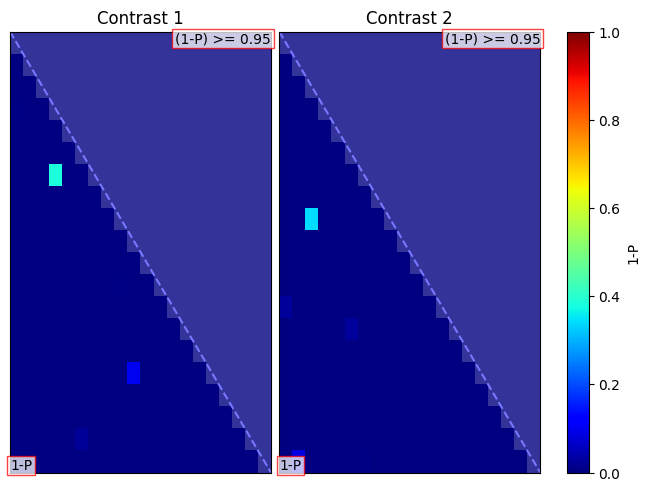

---------------------------------   Subgroups analysis any_test_DTH_slips [with full correlation]:   ---------------------------------
43386

------------------------------
Contrast 1 [1 -1] - no results
------------------------------


-----------------
Contrast 2 [-1 1]
-----------------

Node i | Node j | T statistic | P value
------ | ------ | ----------- | -------
9      | 10     | 4.3010354   | 0.9762 


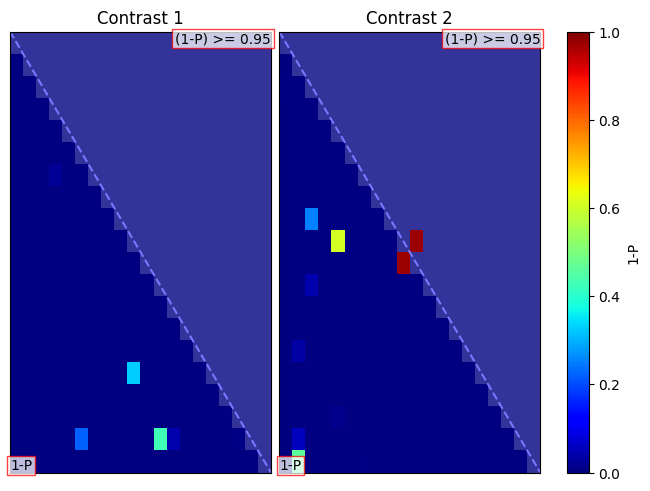

Design matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_subgroup_comparison/input_data/design_behav_subgroups_any_combined_DTH_slips.mat' created successfully!
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_subgroup_comparison/input_data/design_behav_subgroups_any_combined_DTH_slips.con' created successfully!

---------------------------------   Subgroups analysis any_combined_DTH_slips [with partial correlation]:   ---------------------------------
43481

------------------------------
Contrast 1 [1 -1] - no results
------------------------------


------------------------------
Contrast 2 [-1 1] - no results
------------------------------



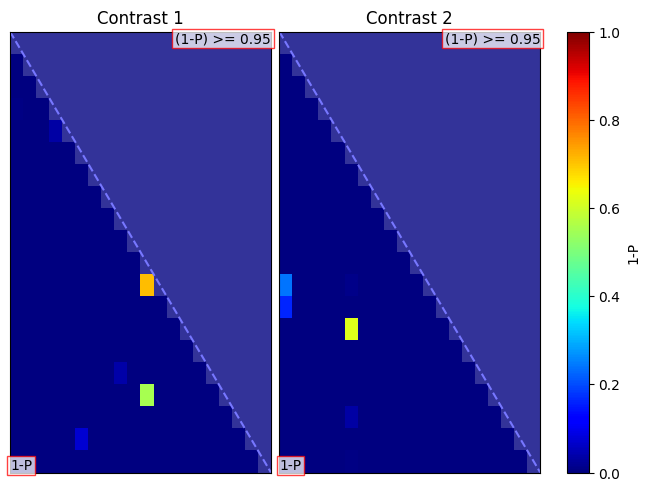

---------------------------------   Subgroups analysis any_combined_DTH_slips [with full correlation]:   ---------------------------------
43565

------------------------------
Contrast 1 [1 -1] - no results
------------------------------


-----------------
Contrast 2 [-1 1]
-----------------

Node i | Node j | T statistic | P value
------ | ------ | ----------- | -------
9      | 10     | 4.077016    | 0.9596 


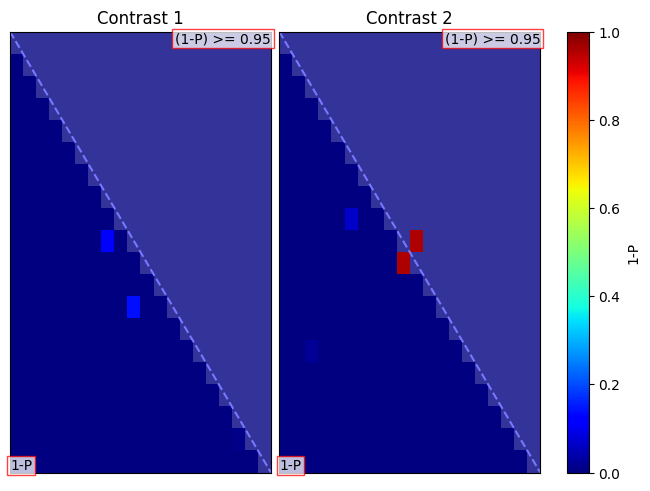

Design matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_subgroup_comparison/input_data/design_behav_subgroups_any_App_slips.mat' created successfully!
Contrast matrix file '/export/home/ranigera/IDCH-rsfMRI/data/whole_networks/univariateICA20.behavior_subgroup_comparison/input_data/design_behav_subgroups_any_App_slips.con' created successfully!

---------------------------------   Subgroups analysis any_App_slips [with partial correlation]:   ---------------------------------
43656

------------------------------
Contrast 1 [1 -1] - no results
------------------------------


------------------------------
Contrast 2 [-1 1] - no results
------------------------------



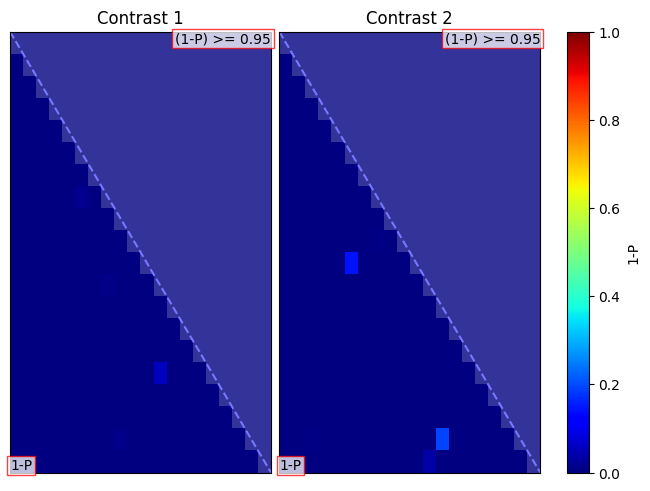

---------------------------------   Subgroups analysis any_App_slips [with full correlation]:   ---------------------------------
43744

------------------------------
Contrast 1 [1 -1] - no results
------------------------------


------------------------------
Contrast 2 [-1 1] - no results
------------------------------



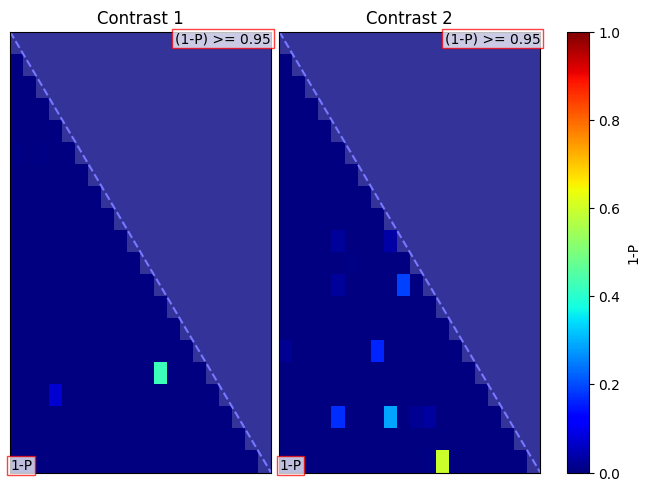

In [61]:
for behav_var in behav_vars_if_interest:
    network_univariate_subgroup_by_behav_analysis(behav_var, n_ICs=20)

# Classifying based on the whole network

## Get behavior data

In [7]:
# load the behavior data:
main_behav_data = pd.read_csv(main_behav_file)
# change subID to int:
main_behav_data['subID'] = main_behav_data['subID'].astype(int)
main_behav_data['any_test_DTH_slips'] = (main_behav_data['at_least_one_response_test']>0).astype(float)
main_behav_data['any_combined_DTH_slips'] = (main_behav_data['at_least_one_response_combined']>0).astype(float)
# now binarize for meanVal_relativeDiff_deval_SQRT:
main_behav_data['any_App_slips'] = (main_behav_data['meanVal_relativeDiff_deval_SQRT']<1).astype(float)
behav_vars_if_interest = ['any_test_DTH_slips', 'any_combined_DTH_slips', 'any_App_slips']
main_behav_data

,subID,sequenceCompleted_test,sequenceCompleted_reacquisition,sequenceCompleted_combined,at_least_one_response_test,at_least_one_response_reacquisition,at_least_one_response_combined,devaluation,stillVal_minus_deval,preVal_relativeDiff_deval,...,std_diary,normed_std_diary,SRM_score,mood,Anxiety,Stress,routine_mean,any_test_DTH_slips,any_combined_DTH_slips,any_App_slips
0,101,1,11,12,1,11,12,0,34,1.000000,...,1281.631619,0.530220,2.200000,71.985294,34.367647,26.191176,3.593137,1.0,1.0,0.0
1,102,0,0,0,0,0,0,0,5,1.000000,...,966.548720,0.433184,4.125000,68.357143,22.000000,21.828571,3.638095,0.0,0.0,0.0
2,103,0,0,0,0,0,0,6,1,0.076923,...,761.555304,0.372977,6.000000,63.100000,20.471429,18.957143,3.823810,0.0,0.0,1.0
3,104,0,0,0,0,0,0,3,12,0.666667,...,1200.262012,0.519515,3.058824,68.457143,14.714286,14.814286,4.095238,0.0,0.0,1.0
4,105,3,0,3,4,0,4,0,9,1.000000,...,1444.988375,0.595996,1.882353,62.536232,33.927536,42.318841,4.376812,1.0,1.0,0.0
5,106,1,0,1,2,0,2,4,26,0.764706,...,NaN,NaN,NaN,90.724138,3.896552,9.327586,5.902299,1.0,1.0,1.0
6,107,0,0,0,0,0,0,0,10,1.000000,...,1376.074428,0.555342,1.954545,66.402985,42.507463,37.104478,4.457711,0.0,0.0,0.0
7,108,0,0,0,0,0,0,0,3,1.000000,...,1065.073426,0.452931,1.571429,70.609375,25.718750,15.906250,5.072917,0.0,0.0,0.0
8,109,0,0,0,0,0,0,2,25,0.862069,...,971.316793,0.462965,3.000000,86.630769,3.384615,5.400000,5.907692,0.0,0.0,1.0
9,110,0,0,0,1,0,1,7,7,0.333333,...,1014.818277,0.480114,4.600000,66.428571,12.442857,28.271429,5.219048,1.0,1.0,1.0


# NOTE!
Below is the FSL function for classify (the nets.classify)
1) The last 4 lines are actually wrong in  my (and chatGPT's) understanding because it tries to predict all the data based on the model from the last iteration of the leave one out cross validation whichi does not make sense.
2) In any case, the important score is the "Accuracy during training:..." part. This is the crossvalidation result.
3) I created the classify_when_multiple_sub_session to not include any subject data in the training when it is the "one out" in the cross validation. So effectively it is like leave two out (by the same subject) for each round

In [8]:
#!/usr/bin/env python
#
# classify.py - Train a classifier on netmats to diffentiate groups.

# Author: Paul McCarthy <pauldmccarthy@gmail.com>
#

import warnings

import numpy                          as     np
from   sklearn.pipeline               import Pipeline
from   sklearn.preprocessing          import StandardScaler
from   sklearn.discriminant_analysis  import QuadraticDiscriminantAnalysis
from   sklearn.model_selection        import LeaveOneOut


def classify(netmats, groups, classifier=None, print_folds=True):
    """Train a machine-learning classifier to differentiate groups based on
    netmat edge strengths.

    netmats:    (runs, edges) array containing per-subject netmats.
    groups:     Number of subjects in each group
    classifier: scikit-learn classifier object. The default is to use a
                QuadraticDiscriminantAnalysis classifier.
    """

    if classifier is None:
        classifier = QuadraticDiscriminantAnalysis(store_covariance=True)

    labels = np.zeros(netmats.shape[0], dtype=int)

    for i, group in enumerate(groups):
        start             = int(np.sum(groups[:i]))
        end               = start + group
        labels[start:end] = i

    pipe = Pipeline([('preproc', StandardScaler()),
                     ('fit',     classifier)])

    loo = LeaveOneOut()

    predictions = np.zeros(labels.shape, dtype=int)
    for fold, (train, test) in enumerate(loo.split(netmats)):

        test_label   =  labels[test[0]]
        train_labels = [labels[i] for i in train]

        # Suppress this warning:
        #   sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            pipe.fit(netmats[train], train_labels)
            result = pipe.predict(netmats[test])[0]

        predictions[fold] = result

        if print_folds:
            print(f'Training fold {fold+1:2d} label: {test_label}, prediction: {result}')

    correct  = (labels == predictions).sum()
    accuracy = correct / len(labels)

    print(f'Accuracy during training: {100 * accuracy:0.2f}%')

    # predictions = pipe.predict(netmats)
    # correct     = (labels == predictions).sum()
    # accuracy    = correct / len(labels)
    # print(f'Accuracy on input data:   {100 * accuracy:0.2f}%')


In [34]:
#!/usr/bin/env python
#
# classify.py - Train a classifier on netmats to diffentiate groups.

# Author: Paul McCarthy <pauldmccarthy@gmail.com>
# Editted by Rani Gera 2024

import warnings

import numpy                          as     np
from   sklearn.pipeline               import Pipeline
from   sklearn.preprocessing          import StandardScaler
from   sklearn.discriminant_analysis  import QuadraticDiscriminantAnalysis
from   sklearn.model_selection        import GroupKFold

from   sklearn.model_selection        import LeaveOneOut


def classify_when_multiple_sub_session(netmats, groups, per_sess_sub_list, classifier=None, print_folds=True):
    """Train a machine-learning classifier to differentiate groups based on
    netmat edge strengths.

    netmats:    (runs, edges) array containing per-subject netmats.
    groups:     Number of subjects in each group
    per_sess_sub_list: List of participant IDs corresponding to each run (for GroupKFold).
    classifier: scikit-learn classifier object. The default is to use a
                QuadraticDiscriminantAnalysis classifier.
    """

    # if per_sess_sub_list not a list, make it a list:
    if not isinstance(per_sess_sub_list, list):
        per_sess_sub_list = list(per_sess_sub_list)
    
    # if per_sess_sub_list has unique values, duplicate each value twice:
    if len(per_sess_sub_list) == len(np.unique(per_sess_sub_list)):
        per_sess_sub_list = [sub for sub in per_sess_sub_list for _ in (0, 1)]

    if classifier is None:
        classifier = QuadraticDiscriminantAnalysis(store_covariance=True)

    labels = np.zeros(netmats.shape[0], dtype=int)

    for i, group in enumerate(groups):
        start             = int(np.sum(groups[:i]))
        end               = start + group
        labels[start:end] = i

    pipe = Pipeline([('preproc', StandardScaler()),
                     ('fit',     classifier)])

    # Using GroupKFold to ensure data from the same participant is not split between train/test
    group_kfold = GroupKFold(n_splits=len(np.unique(per_sess_sub_list)))

    predictions = np.zeros(labels.shape, dtype=int)

    for fold, (train_idx, test_idx) in enumerate(group_kfold.split(netmats, labels, groups=per_sess_sub_list)):
        train_data, test_data = netmats[train_idx], netmats[test_idx]
        train_labels, test_labels = labels[train_idx], labels[test_idx]

        # Suppress collinearity warnings
        #   sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            pipe.fit(train_data, train_labels)
            result = pipe.predict(test_data)
            # print(pipe.predict_proba(test_data)) # and theb I can use for example SVC(probability=True) in the classifier

        predictions[test_idx] = result

        if print_folds:
            for i, (true_label, predicted_label) in enumerate(zip(test_labels, result)):
                print(f'Training fold {fold+1:2d} label: {true_label}, prediction: {predicted_label}')

    correct  = (labels == predictions).sum()
    accuracy = correct / len(labels)
    # check accuracy if guess the majority class:
    majority_class = np.argmax(np.bincount(labels))

    print(f'Accuracy during cross-validation: {100 * accuracy:0.2f}%')

    # # Optional: Train on all data and predict on the same data (useful for final model deployment)
    # pipe.fit(netmats, labels)
    # predictions = pipe.predict(netmats)
    # correct     = (labels == predictions).sum()
    # accuracy    = correct / len(labels)
    # print(f'Accuracy on the entire dataset:   {100 * accuracy:0.2f}%')

# classify_when_multiple_sub_session(Pnetmats, (n_0s*2, n_1s*2), behav_data.subID)

In [62]:
behav_vars_if_interest = ['any_test_DTH_slips', 'any_combined_DTH_slips', 'any_App_slips']

def prepare_for_classification(main_behav_data ,behav_var, concatenate_sub_runs=False, n_ICs=20):

    # get the data with subID and the behavior variable (and remove NaNs):
    behav_data = main_behav_data[['subID', behav_var]].dropna().reset_index(drop=True)
    # re-arange data to have all 1 in a row and all 0 in a row:
    behav_data = behav_data.sort_values(by=[behav_var,'subID'], ascending=[True, True]).reset_index(drop=True)
    n_0s = int((behav_data[behav_var] == 0).sum()) # Goal-directed
    n_1s = int((behav_data[behav_var] == 1).sum()) # Habitual

    nruns = 1 if concatenate_sub_runs else 2
    ## Load as the relevant data as a ts object:
    relevant_files = [f'{concat_ts_path}/dr_stage1_{subj}.txt' for subj in behav_data.subID]
    ts = nets.load(relevant_files, 0.70, varnorm=0, nruns=nruns, thumbnaildir=f'{group_ICA_path}/groupICA{n_ICs}.sum')
    Fnetmats = nets.netmats(ts, 'corr',   True)
    Pnetmats = nets.netmats(ts, 'ridgep', True, 0.1) # partial correlations with regularization

    return behav_data, ts, Fnetmats, Pnetmats, n_0s, n_1s


def run_classification_for_behav_vars(behav_vars_of_interest, main_behav_data, classifier=None, n_ICs=20, print_folds=False):
    print (f'\n>>>>>>>>>>>>>>>>>> Classifier: {classifier} <<<<<<<<<<<<<<<<<<')
    for behav_var in behav_vars_of_interest:
        behav_data, ts, Fnetmats, Pnetmats, n_0s, n_1s = prepare_for_classification(main_behav_data, behav_var, concatenate_sub_runs=False, n_ICs=n_ICs)
        behav_data, ts_completely_concat, Fnetmats_completely_concat, Pnetmats_completely_concat, n_0s, n_1s = prepare_for_classification(main_behav_data, behav_var, concatenate_sub_runs=True, n_ICs=n_ICs)
        print(f'---------------------------------   {behav_var}   ---------------------------------')
        # print(f'>>> Partial corr (regular, leave ine time series out, include all others, including the participants)')
        # classify(Pnetmats, (n_0s*2, n_1s*2), classifier=classifier, print_folds=print_folds)
        # print(f'>>> Full corr (regular, leave ine time series out, include all others, including the participants)')
        # classify(Fnetmats, (n_0s*2, n_1s*2), classifier=classifier, print_folds=print_folds)
        print(f'>>> Partial corr (time series per subject completely concatenated)')
        classify(Pnetmats_completely_concat, (n_0s, n_1s), classifier=classifier, print_folds=print_folds)
        print(f'>>> Full corr (time series per subject completely concatenated)')
        classify(Fnetmats_completely_concat, (n_0s, n_1s), classifier=classifier, print_folds=print_folds)
        print(f'>>> Partial corr (leave 2 out (of the same subject) cross validation)')
        classify_when_multiple_sub_session(Pnetmats, (n_0s*2, n_1s*2), behav_data.subID, classifier=classifier, print_folds=print_folds)
        print(f'>>> Full corr (leave 2 out (of the same subject) cross validation)')
        classify_when_multiple_sub_session(Fnetmats, (n_0s*2, n_1s*2), behav_data.subID, classifier=classifier, print_folds=print_folds)




In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier # Multi layer perceptron
from sklearn.tree import DecisionTreeClassifier

run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=QuadraticDiscriminantAnalysis(), n_ICs=20, print_folds=False) # DEFAULT is QuadraticDiscriminantAnalysis, so without this argument we'll get the same result
run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=LinearDiscriminantAnalysis(), n_ICs=20, print_folds=False) # DEFAULT is QuadraticDiscriminantAnalysis, so without this argument we'll get the same result
run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=RandomForestClassifier(), n_ICs=20, print_folds=False)
run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=SVC(), n_ICs=20, print_folds=False)
run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=SVC(kernel='linear'), n_ICs=20, print_folds=False)
run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=SVC(kernel='poly'), n_ICs=20, print_folds=False)
run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=SVC(kernel='sigmoid'), n_ICs=20, print_folds=False)
run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=LogisticRegression(), n_ICs=20, print_folds=False)
run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=GradientBoostingClassifier(), n_ICs=20, print_folds=False)
run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=KNeighborsClassifier(n_neighbors=3), n_ICs=20, print_folds=False)
run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=GaussianNB(), n_ICs=20, print_folds=False)
run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=BernoulliNB(), n_ICs=20, print_folds=False)
run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=AdaBoostClassifier(n_estimators=50), n_ICs=20, print_folds=False)
run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), n_ICs=20, print_folds=False)
run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=MLPClassifier(hidden_layer_sizes=(100,), max_iter=300), n_ICs=20, print_folds=False) # Neuroal network
run_classification_for_behav_vars(behav_vars_if_interest, main_behav_data, classifier=DecisionTreeClassifier(), n_ICs=20, print_folds=False)






---------------------------------   any_test_DTH_slips   ---------------------------------
>>> Partial corr (regular, leave ine time series out, include all others, including the participants)
Accuracy during training: 54.76%
>>> Full corr (regular, leave ine time series out, include all others, including the participants)
Accuracy during training: 66.67%
>>> Partial corr (time series per subject completely concatenated)
Accuracy during training: 61.90%
>>> Full corr (time series per subject completely concatenated)
Accuracy during training: 42.86%
>>> Partial corr (leave 2 out (of the same subject) cross validation)
Accuracy during cross-validation: 33.33%
>>> Full corr (leave 2 out (of the same subject) cross validation)
Accuracy during cross-validation: 52.38%
---------------------------------   any_combined_DTH_slips   ---------------------------------
>>> Partial corr (regular, leave ine time series out, include all others, including the participants)
Accuracy during training: 64.

---------------------------------   any_test_DTH_slips   ---------------------------------
>>> Partial corr (regular, leave ine time series out, include all others, including the participants)
Accuracy during training: 45.24%
>>> Full corr (regular, leave ine time series out, include all others, including the participants)
Accuracy during training: 59.52%
>>> Partial corr (time series per subject completely concatenated)
Accuracy during training: 57.14%
>>> Full corr (time series per subject completely concatenated)
Accuracy during training: 42.86%
>>> Partial corr (leave 2 out (of the same subject) cross validation)
Accuracy during cross-validation: 35.71%
>>> Full corr (leave 2 out (of the same subject) cross validation)
Accuracy during cross-validation: 50.00%
---------------------------------   any_combined_DTH_slips   ---------------------------------
>>> Partial corr (regular, leave ine time series out, include all others, including the participants)
Accuracy during training: 57.

Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.


---------------------------------   any_test_DTH_slips   ---------------------------------
>>> Partial corr (regular, leave ine time series out, include all others, including the participants)
Accuracy during training: 54.76%
>>> Full corr (regular, leave ine time series out, include all others, including the participants)
Accuracy during training: 66.67%
>>> Partial corr (time series per subject completely concatenated)
Accuracy during training: 71.43%
>>> Full corr (time series per subject completely concatenated)
Accuracy during training: 38.10%
>>> Partial corr (leave 2 out (of the same subject) cross validation)
Accuracy during cross-validation: 40.48%
>>> Full corr (leave 2 out (of the same subject) cross validation)
Accuracy during cross-validation: 54.76%
---------------------------------   any_combined_DTH_slips   ---------------------------------
>>> Partial corr (regular, leave ine time series out, include all others, including the participants)
Accuracy during training: 64.

---------------------------------   any_test_DTH_slips   ---------------------------------
>>> Partial corr (regular, leave ine time series out, include all others, including the participants)
Accuracy during training: 80.95%
>>> Full corr (regular, leave ine time series out, include all others, including the participants)
Accuracy during training: 73.81%
>>> Partial corr (time series per subject completely concatenated)
Accuracy during training: 38.10%
>>> Full corr (time series per subject completely concatenated)
Accuracy during training: 52.38%
>>> Partial corr (leave 2 out (of the same subject) cross validation)
Accuracy during cross-validation: 42.86%
>>> Full corr (leave 2 out (of the same subject) cross validation)
Accuracy during cross-validation: 40.48%
---------------------------------   any_combined_DTH_slips   ---------------------------------
>>> Partial corr (regular, leave ine time series out, include all others, including the participants)
Accuracy during training: 88.

---------------------------------   any_test_DTH_slips   ---------------------------------
>>> Partial corr (regular, leave ine time series out, include all others, including the participants)
Accuracy during training: 42.86%
>>> Full corr (regular, leave ine time series out, include all others, including the participants)
Accuracy during training: 66.67%
>>> Partial corr (time series per subject completely concatenated)
Accuracy during training: 47.62%
>>> Full corr (time series per subject completely concatenated)
Accuracy during training: 38.10%
>>> Partial corr (leave 2 out (of the same subject) cross validation)
Accuracy during cross-validation: 26.19%
>>> Full corr (leave 2 out (of the same subject) cross validation)
Accuracy during cross-validation: 57.14%
---------------------------------   any_combined_DTH_slips   ---------------------------------
>>> Partial corr (regular, leave ine time series out, include all others, including the participants)
Accuracy during training: 47.

# NOTE!
Below is the FSL function for classify (the nets.classify)
1) The last 4 lines are actually wrong in  my (and chatGPT's) understanding because it tries to predict all the data based on the model from the last iteration of the leave one out cross validation whichi does not make sense.
2) In any case, the important score is the "Accuracy during training:..." part. This is the crossvalidation result.
3) I created the classify_when_multiple_sub_session to not include any subject data in the training when it is the "one out" in the cross validation. So effectively it is like leave two out (by the same subject) for each round

In [2]:
#!/usr/bin/env python
#
# classify.py - Train a classifier on netmats to diffentiate groups.

# Author: Paul McCarthy <pauldmccarthy@gmail.com>
#

import warnings

import numpy                          as     np
from   sklearn.pipeline               import Pipeline
from   sklearn.preprocessing          import StandardScaler
from   sklearn.discriminant_analysis  import QuadraticDiscriminantAnalysis
from   sklearn.model_selection        import LeaveOneOut


def classify(netmats, groups, classifier=None):
    """Train a machine-learning classifier to differentiate groups based on
    netmat edge strengths.

    netmats:    (runs, edges) array containing per-subject netmats.
    groups:     Number of subjects in each group
    classifier: scikit-learn classifier object. The default is to use a
                QuadraticDiscriminantAnalysis classifier.
    """

    if classifier is None:
        classifier = QuadraticDiscriminantAnalysis(store_covariance=True)

    labels = np.zeros(netmats.shape[0], dtype=int)

    for i, group in enumerate(groups):
        start             = int(np.sum(groups[:i]))
        end               = start + group
        labels[start:end] = i

    pipe = Pipeline([('preproc', StandardScaler()),
                     ('fit',     classifier)])

    loo = LeaveOneOut()

    predictions = np.zeros(labels.shape, dtype=int)
    for fold, (train, test) in enumerate(loo.split(netmats)):

        test_label   =  labels[test[0]]
        train_labels = [labels[i] for i in train]

        # Suppress this warning:
        #   sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            pipe.fit(netmats[train], train_labels)
            result = pipe.predict(netmats[test])[0]

        predictions[fold] = result

        print(f'Training fold {fold+1:2d} label: {test_label}, prediction: {result}')

    correct  = (labels == predictions).sum()
    accuracy = correct / len(labels)

    print(f'Accuracy during training: {100 * accuracy:0.2f}%')

    predictions = pipe.predict(netmats)
    correct     = (labels == predictions).sum()
    accuracy    = correct / len(labels)
    print(f'Accuracy on input data:   {100 * accuracy:0.2f}%')


In [3]:
#!/usr/bin/env python
#
# classify.py - Train a classifier on netmats to diffentiate groups.

# Author: Paul McCarthy <pauldmccarthy@gmail.com>
# Editted by Rani Gera 2024

import warnings

import numpy                          as     np
from   sklearn.pipeline               import Pipeline
from   sklearn.preprocessing          import StandardScaler
from   sklearn.discriminant_analysis  import QuadraticDiscriminantAnalysis
from   sklearn.model_selection        import GroupKFold

from   sklearn.model_selection        import LeaveOneOut


def classify_when_multiple_sub_session(netmats, groups, per_sess_sub_list, classifier=None):
    """Train a machine-learning classifier to differentiate groups based on
    netmat edge strengths.

    netmats:    (runs, edges) array containing per-subject netmats.
    groups:     Number of subjects in each group
    per_sess_sub_list: List of participant IDs corresponding to each run (for GroupKFold).
    classifier: scikit-learn classifier object. The default is to use a
                QuadraticDiscriminantAnalysis classifier.
    """

    # if per_sess_sub_list not a list, make it a list:
    if not isinstance(per_sess_sub_list, list):
        per_sess_sub_list = list(per_sess_sub_list)
    
    # if per_sess_sub_list has unique values, duplicate each value twice:
    if len(per_sess_sub_list) == len(np.unique(per_sess_sub_list)):
        per_sess_sub_list = [sub for sub in per_sess_sub_list for _ in (0, 1)]

    if classifier is None:
        classifier = QuadraticDiscriminantAnalysis(store_covariance=True)

    labels = np.zeros(netmats.shape[0], dtype=int)

    for i, group in enumerate(groups):
        start             = int(np.sum(groups[:i]))
        end               = start + group
        labels[start:end] = i

    pipe = Pipeline([('preproc', StandardScaler()),
                     ('fit',     classifier)])

    # Using GroupKFold to ensure data from the same participant is not split between train/test
    group_kfold = GroupKFold(n_splits=len(np.unique(per_sess_sub_list)))

    predictions = np.zeros(labels.shape, dtype=int)

    for fold, (train_idx, test_idx) in enumerate(group_kfold.split(netmats, labels, groups=per_sess_sub_list)):
        train_data, test_data = netmats[train_idx], netmats[test_idx]
        train_labels, test_labels = labels[train_idx], labels[test_idx]

        # Suppress collinearity warnings
        #   sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            pipe.fit(train_data, train_labels)
            result = pipe.predict(test_data)

        predictions[test_idx] = result

        for i, (true_label, predicted_label) in enumerate(zip(test_labels, result)):
            print(f'Training fold {fold+1:2d} label: {true_label}, prediction: {predicted_label}')

    correct  = (labels == predictions).sum()
    accuracy = correct / len(labels)

    print(f'Accuracy during cross-validation: {100 * accuracy:0.2f}%')

    # # Optional: Train on all data and predict on the same data (useful for final model deployment)
    # pipe.fit(netmats, labels)
    # predictions = pipe.predict(netmats)
    # correct     = (labels == predictions).sum()
    # accuracy    = correct / len(labels)
    # print(f'Accuracy on the entire dataset:   {100 * accuracy:0.2f}%')

classify_when_multiple_sub_session(Pnetmats, (n_0s*2, n_1s*2), behav_data.subID)

NameError: name 'Pnetmats' is not defined

In [ ]:
#!/usr/bin/env python
#
# classify.py - Train a classifier on netmats to diffentiate groups.

# Author: Paul McCarthy <pauldmccarthy@gmail.com>
#

import warnings

import numpy                          as     np
from   sklearn.pipeline               import Pipeline
from   sklearn.preprocessing          import StandardScaler
from   sklearn.discriminant_analysis  import QuadraticDiscriminantAnalysis
from   sklearn.model_selection        import LeaveOneOut

netmats = Pnetmats
groups  = (n_0s*2, n_1s*2)
classifier=None

"""Train a machine-learning classifier to differentiate groups based on
netmat edge strengths.

netmats:    (runs, edges) array containing per-subject netmats.
groups:     Number of subjects in each group
classifier: scikit-learn classifier object. The default is to use a
            QuadraticDiscriminantAnalysis classifier.
"""

if classifier is None:
    classifier = QuadraticDiscriminantAnalysis(store_covariance=True)

labels = np.zeros(netmats.shape[0], dtype=int)

for i, group in enumerate(groups):
    start             = int(np.sum(groups[:i]))
    end               = start + group
    labels[start:end] = i

pipe = Pipeline([('preproc', StandardScaler()),
                    ('fit',     classifier)])

loo = LeaveOneOut()

predictions = np.zeros(labels.shape, dtype=int)
for fold, (train, test) in enumerate(loo.split(netmats)):

    test_label   =  labels[test[0]]
    train_labels = [labels[i] for i in train]

    # Suppress this warning:
    #   sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        pipe.fit(netmats[train], train_labels)
        result = pipe.predict(netmats[test])[0]

    predictions[fold] = result

    print(f'Training fold {fold+1:2d} label: {test_label}, prediction: {result}')

correct  = (labels == predictions).sum()
accuracy = correct / len(labels)

print(f'Accuracy during training: {100 * accuracy:0.2f}%')

predictions = pipe.predict(netmats)
correct     = (labels == predictions).sum()
accuracy    = correct / len(labels)
print(f'Accuracy on input data:   {100 * accuracy:0.2f}%')
